In [24]:
import cv2
import numpy as np
import sympy as sp
from sklearn.covariance import EmpiricalCovariance
from sklearn.datasets import make_gaussian_quantiles
from scipy.linalg import expm, sinm, cosm
from matplotlib import pyplot as plt
import numpy.ma as ma
import math

In [25]:
def ssc(keypoints, num_ret_points, tolerance, cols, rows):
    exp1 = rows + cols + 2 * num_ret_points
    exp2 = (
        4 * cols
        + 4 * num_ret_points
        + 4 * rows * num_ret_points
        + rows * rows
        + cols * cols
        - 2 * rows * cols
        + 4 * rows * cols * num_ret_points
    )
    exp3 = math.sqrt(exp2)
    exp4 = num_ret_points - 1

    sol1 = -round(float(exp1 + exp3) / exp4)  # first solution
    sol2 = -round(float(exp1 - exp3) / exp4)  # second solution

    high = (
        sol1 if (sol1 > sol2) else sol2
    )  # binary search range initialization with positive solution
    low = math.floor(math.sqrt(len(keypoints) / num_ret_points))

    prev_width = -1
    selected_keypoints = []
    result_list = []
    result = []
    complete = False
    k = num_ret_points
    k_min = round(k - (k * tolerance))
    k_max = round(k + (k * tolerance))

    while not complete:
        width = low + (high - low) / 2
        if (
            width == prev_width or low > high
        ):  # needed to reassure the same radius is not repeated again
            result_list = result  # return the keypoints from the previous iteration
            break

        c = width / 2  # initializing Grid
        num_cell_cols = int(math.floor(cols / c))
        num_cell_rows = int(math.floor(rows / c))
        covered_vec = [
            [False for _ in range(num_cell_cols + 1)] for _ in range(num_cell_rows + 1)
        ]
        result = []

        for i in range(len(keypoints)):
            row = int(
                math.floor(keypoints[i].pt[1] / c)
            )  # get position of the cell current point is located at
            col = int(math.floor(keypoints[i].pt[0] / c))
            if not covered_vec[row][col]:  # if the cell is not covered
                result.append(i)
                # get range which current radius is covering
                row_min = int(
                    (row - math.floor(width / c))
                    if ((row - math.floor(width / c)) >= 0)
                    else 0
                )
                row_max = int(
                    (row + math.floor(width / c))
                    if ((row + math.floor(width / c)) <= num_cell_rows)
                    else num_cell_rows
                )
                col_min = int(
                    (col - math.floor(width / c))
                    if ((col - math.floor(width / c)) >= 0)
                    else 0
                )
                col_max = int(
                    (col + math.floor(width / c))
                    if ((col + math.floor(width / c)) <= num_cell_cols)
                    else num_cell_cols
                )
                for row_to_cover in range(row_min, row_max + 1):
                    for col_to_cover in range(col_min, col_max + 1):
                        if not covered_vec[row_to_cover][col_to_cover]:
                            # cover cells within the square bounding box with width w
                            covered_vec[row_to_cover][col_to_cover] = True

        if k_min <= len(result) <= k_max:  # solution found
            result_list = result
            complete = True
        elif len(result) < k_min:
            high = width - 1  # update binary search range
        else:
            low = width + 1
        prev_width = width

    for i in range(len(result_list)):
        selected_keypoints.append(keypoints[result_list[i]])

    return selected_keypoints

In [26]:
def pixel_coord_normalization(K, x):
    return np.linalg.inv(K).dot(x)

In [27]:
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

In [28]:
def projection(x, y):
    return x * np.inner(x, y) / np.inner(x, x)

In [29]:
def finding_bases(t):
    idx = 0
    if np.abs(t[1]) < np.abs(t[idx]):
        idx = 1
    if np.abs(t[2]) < np.abs(t[idx]):
        idx = 2
        
    if idx == 0:
        b1 = np.array([0,1,0])
        b2 = np.array([0,0,1])
    elif idx == 1:
        b1 = np.array([1,0,0])
        b2 = np.array([0,0,1])
    else:
        b1 = np.array([1,0,0])
        b2 = np.array([0,1,0])
        
    b1 = b1 - projection(t, b1)
    b1 = b1/np.linalg.norm(b1)
    b2 = b2 - projection(t, b2) - projection(b1, b2)
    b2 = b2/np.linalg.norm(b2)
    return b1, b2

In [30]:
def jacobian(t, R, fl, fr, b1, b2): 
    first_el = -(fr.T).dot(skew(t)).dot(R).dot(skew(fl))
    second_el = np.array([(fr.T).dot(skew(b1)).dot(R).dot(fl), (fr.T).dot(skew(b2)).dot(R).dot(fl)])
    return np.array([*first_el, *second_el])

In [31]:
def ri(t, R, fl, fr):
    return (fr.T).dot(skew(t)).dot(R).dot(fl)

In [32]:
def delta(J, r, W=np.identity(5)):
    return -np.linalg.inv(J.T @ W @ J) @ J.T @ W .dot(r)

In [33]:
dataset_num = 1

### Features match 1 (SIFT)

In [11]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

img1 = cv2.imread(f'images/left{dataset_num}.png')    #queryimage # left image
img2 = cv2.imread(f'images/right{dataset_num}.png')   #trainimage # right image

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

keypoints_left, descriptors_left = sift.detectAndCompute(img1,None)
keypoints_right, descriptors_right = sift.detectAndCompute(img2,None)

matches = bf.match(descriptors_left,descriptors_right)
matches = sorted(matches, key = lambda x:x.distance)

### Features match 2 (FastFeatureDetector + BRIEF)

In [34]:
# https://github.com/BAILOOL/ANMS-Codes

img1 = cv2.imread(f'images/left{dataset_num}.png')
img2 = cv2.imread(f'images/right{dataset_num}.png')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fast = cv2.FastFeatureDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

keypoints_left = fast.detect(img1, None)
keypoints_right = fast.detect(img2, None)

keypoints_left = sorted(keypoints_left, key=lambda x: x.response, reverse=True)
keypoints_right = sorted(keypoints_right, key=lambda x: x.response, reverse=True)
print(f'FAST Features: {len(keypoints_left)}')

selected_keypoints1 = ssc(
    keypoints_left, 10000, 1e-01, img1.shape[1], img1.shape[0]
)
selected_keypoints2 = ssc(
    keypoints_right, 10000, 1e-01, img2.shape[1], img2.shape[0]
)
print(f'Selected Features: {len(selected_keypoints1)}')

keypoints_left, descriptors_left = brief.compute(img1, selected_keypoints1)
keypoints_right, descriptors_right = brief.compute(img2, selected_keypoints2)
print(f'Keypoints with desc: {len(keypoints_left)}')

matches = bf.match(descriptors_left,descriptors_right)
matches = sorted(matches, key = lambda x:x.distance)
print(f'Matches: {len(matches)}')

FAST Features: 83915
Selected Features: 12716
Keypoints with desc: 11729
Matches: 3448


In [35]:
idx_left = [x.queryIdx for x in matches]
idx_right = [x.trainIdx for x in matches]

coords_left = np.array([[*keypoints_left[i].pt, 1.] for i in idx_left])
coords_right = np.array([[*keypoints_right[i].pt, 1.] for i in idx_right])

In [36]:
exact_Rs = [np.array([[9.9990549879940105e-01, -7.5019414964265820e-03, -1.1520171201209756e-02],
                      [7.2858186542670792e-03, 9.9979879644645819e-01, -1.8689127072999068e-02],
                      [1.1658058039747596e-02, 1.8603427049814391e-02, 9.9975897204513453e-01]]),
            
            np.array([[9.9993148262771858e-01, -6.8381673743507926e-03, -9.5010271493625609e-03],
                      [6.6700706261733685e-03, 9.9982263176414121e-01, -1.7612926221053014e-02],
                      [9.6197821063898990e-03, 1.7548346907522713e-02, 9.9979973760400576e-01]])
            ]
exact_ts = [np.array([-1.0054615507162461e+00, -1.2445275861032211e-02, -3.7161139312850124e-02 ]),
            np.array([-1.0057109534289157e+00, -1.0091959156006969e-02, -1.8672493781540369e-02])
           ]

left_camera_matrices = [np.array([[2.8684780535996128e+03, 0., 9.5950000000000000e+02],                            
                                  [0., 3.0597099238395872e+03, 5.3950000000000000e+02],
                                  [0., 0., 1.]]),
                        np.array([[2.7986162739260899e+03, 0., 9.5950000000000000e+02], 
                                  [0., 2.9851906921878294e+03, 5.3950000000000000e+02], 
                                  [0., 0., 1.]])
                       ]

right_camera_matrices = [np.array([[2.8741139085480700e+03, 0., 9.5950000000000000e+02], 
                                   [0., 3.0657215024512748e+03, 5.3950000000000000e+02],
                                   [0., 0., 1.]]),
                         np.array([[2.8030785191464979e+03, 0., 9.5950000000000000e+02],
                                   [0., 2.9899504204229311e+03, 5.3950000000000000e+02],
                                   [0., 0., 1.]])
                        ]
left_dist = [np.array([ -2.8970594823114904e-01, 0., 0., 0., 0. ]),
             np.array([-3.0195605175804907e-01, 0., 0., 0., 0.])
            ]
right_dist = [np.array([ -2.9565176913509805e-01, 0., 0., 0., 0. ]),
              np.array([-2.8760404110746712e-01, 0., 0., 0., 0.])
             ]
current_Rs = [np.array([[9.9e-01, -7.5e-03, -1.1e-02],
                        [7.2e-03, 9.9e-01, -1.8e-02],
                        [1.1e-02, 1.8e-02, 9.9e-01]]),
              np.array([[9.0e-01, -6.83e-03, -9.50e-03],
                        [6.67e-03, 9.9e-01, -1.76e-02],
                        [9.61e-03, 1.75e-02, 9.9e-01]])
             ]
current_ts = [np.array([-1.0e+00, -2.2e-02, -3.7e-02]),
              np.array([-1.0e+00, -1.0e-02, -1.8e-02])
             ]

R = current_Rs[dataset_num] 
t = current_ts[dataset_num]
left_cam_matrix = left_camera_matrices[dataset_num]
right_cam_matrix = right_camera_matrices[dataset_num]
dist1 = left_dist[dataset_num]
dist2 = right_dist[dataset_num]

In [37]:
fl = np.array([pixel_coord_normalization(left_cam_matrix, coords_left[i]) for i in range(len(coords_left))])
fr = np.array([pixel_coord_normalization(right_cam_matrix, coords_right[i]) for i in range(len(coords_left))])

epipolar_error = 0
epsilon = 1e-07
correspondence_index = []
for i in range(len(coords_left)):
    correspondence_error = ((fr[i].T).dot(skew(t)).dot(R).dot(fl[i]))**2
    if correspondence_error < epsilon:
        epipolar_error += correspondence_error
        correspondence_index.append(i)
fl = fl[correspondence_index]
fr = fr[correspondence_index]
n = len(fl)
print(f'Amount of features: {n}')
print(f'Epipolar error: {(epipolar_error/n)**0.5*left_cam_matrix[1][1]}')

Amount of features: 382
Epipolar error: 0.49639077398938874


In [18]:
matches = np.array(matches)
img3 = cv2.drawMatches(img1, keypoints_left, img2, keypoints_right, matches[correspondence_index], img2, flags=2)

cv2.imshow('Correspondences', cv2.resize(img3, (1920,540)))
cv2.waitKey(0)

# for Fast+BRIEF Features
#img3 = cv2.drawKeypoints(img1, np.array(keypoints_left)[correspondence_index], outImage=None, color=(255, 0, 0))
#cv2.imshow("After epipolar", img3)
#cv2.waitKey(0)

-1

### R and t calibration

In [38]:
w_n = []
for i in range(n):
    w_n.append(np.dot(fl[i], fl[i])*np.dot(fr[i], fr[i]))
w_n = np.array(w_n)

ct = 2**0.5                   # Huber norm threshold
 

for k in range(100):
    b1, b2 = finding_bases(t)    
    J = np.array([jacobian(t, R, fl[i], fr[i], b1, b2) for i in range(n)])    
    r = np.array([ri(t, R, fl[i], fr[i]) for i in range(n)])
    w_h = np.array([ct/np.abs(r[i]) if np.abs(r[i]) > ct else 1 for i in range(n)])
    W = np.diag(w_n*w_h)
    d = delta(J, r, W)
    
    print(f'------------------ Iteration #{k} ---------------------')
    print(f'ROTATION = {R}') 
    print(f'TRANSLATION = {t}')
    #print(f'B1 = {b1}')
    #print(f'B2 = {b2}')
    #print(f'J = {J}')
    #print(f'r = {r}')
    #print(f'W = {W}')
    print(f'DELTA = {d}')
    
    R = R.dot(expm(skew(d[:3])))
    t = t + d[-2]*b1 + d[-1]*b2
    #t /= np.linalg.norm(t) 

------------------ Iteration #0 ---------------------
ROTATION = [[ 0.9     -0.00683 -0.0095 ]
 [ 0.00667  0.99    -0.0176 ]
 [ 0.00961  0.0175   0.99   ]]
TRANSLATION = [-1.    -0.01  -0.018]
DELTA = [-0.00010255  0.00608929 -0.00022979 -0.00349382  0.00226724]
------------------ Iteration #1 ---------------------
ROTATION = [[ 0.90004271 -0.00662249 -0.00402018]
 [ 0.00654925  0.99000332 -0.01745822]
 [ 0.00357745  0.01739998  0.99004194]]
TRANSLATION = [-1.00007193 -0.01028554 -0.01384543]
DELTA = [-1.84027378e-07 -2.91492416e-05 -2.25752981e-06 -2.59894436e-04
  1.62910424e-04]
------------------ Iteration #2 ---------------------
ROTATION = [[ 0.90004261 -0.00662046 -0.00404642]
 [ 0.0065465   0.99000333 -0.01745823]
 [ 0.00360627  0.01739981  0.99004184]]
TRANSLATION = [-1.00007641 -0.01026135 -0.01353969]
DELTA = [-4.00115027e-08  2.11607223e-06  2.43749992e-08  1.74215153e-06
 -9.09196652e-07]
------------------ Iteration #3 ---------------------
ROTATION = [[ 0.90004262 -0.006

------------------ Iteration #28 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [ 1.60936260e-19  4.52112306e-17 -1.30104261e-18 -1.17527515e-16
  1.00071861e-16]
------------------ Iteration #29 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [ 4.01493617e-19  5.73542949e-17  6.37646403e-18  8.84708973e-17
 -7.93635990e-17]
------------------ Iteration #30 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [-5.77676470e-19 -1.13136497e-16 -6.22060996e-18  3.10081821e-17
 -5.74627151e-18]
------------------ 

------------------ Iteration #65 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [ 4.28598671e-19 -6.28837260e-18 -5.94955942e-18 -9.19403442e-17
  5.33427469e-17]
------------------ Iteration #66 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [ 2.10064171e-19  2.87313576e-17  5.27870933e-18 -2.75387352e-17
  1.96240593e-17]
------------------ Iteration #67 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [ 3.18484388e-19 -1.97595846e-17 -3.87602277e-18 -3.89228580e-17
  2.99239800e-17]
------------------ 

------------------ Iteration #92 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [-8.97854924e-20 -9.30787565e-17  6.16639986e-19  4.66206934e-18
  7.91467586e-18]
------------------ Iteration #93 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [-2.35475159e-19  1.10859672e-16  3.29326410e-18 -1.02999206e-17
  5.96311195e-18]
------------------ Iteration #94 ---------------------
ROTATION = [[ 0.90004262 -0.00662048 -0.00404454]
 [ 0.00654656  0.99000334 -0.01745818]
 [ 0.0036042   0.01739977  0.99004185]]
TRANSLATION = [-1.00007638 -0.01026167 -0.01354151]
DELTA = [ 1.34339425e-18 -1.33519498e-16 -1.69406589e-18 -8.20741045e-17
  4.09828421e-17]
------------------ 

### Estimating the Covariance

In [39]:
### https://math.mit.edu/~liewang/ECM.pdf

fs = np.array([*fl, *fr])
cov = EmpiricalCovariance().fit(fs)
cov_mat = sp.Matrix(cov.covariance_)
P, cov_mat = cov_mat.diagonalize()
sigma_f = np.array(cov_mat.tolist(), dtype='float')

sigma_r = []
for i in range(n):
    sigma_r.append((fl[i].T).dot((skew(t).dot(R)).T).dot(sigma_f).dot((skew(t).dot(R))).dot(fl[i]) + \
                   (fr[i].T).dot(skew(t).dot(R)).dot(sigma_f).dot((skew(t).dot(R)).T).dot(fr[i]))

sigma_r = np.diag(sigma_r)
sigma_delta = np.linalg.inv((J.T).dot(np.linalg.inv(sigma_r)).dot(J))
print(np.linalg.eig(sigma_delta)[0])

[2.12025093e+00 2.61260913e-01 1.64166732e-02 2.35074144e-05
 1.30812390e-03]


### Disparity map

In [40]:
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(cameraMatrix1=left_cam_matrix, 
                                                  distCoeffs1=dist1, 
                                                  cameraMatrix2=right_cam_matrix, 
                                                  distCoeffs2=dist2, 
                                                  imageSize=(1920, 1080), 
                                                  R=R, 
                                                  T=t,
                                                  alpha=0,
                                                  flags=cv2.CALIB_ZERO_DISPARITY)

mapxL, mapyL = cv2.initUndistortRectifyMap(cameraMatrix = left_cam_matrix, 
                                           distCoeffs = dist1, 
                                           R = R1, 
                                           newCameraMatrix = P1, 
                                           size = (1920, 1080), 
                                           m1type = cv2.CV_32FC1)
mapxR, mapyR = cv2.initUndistortRectifyMap(right_cam_matrix, 
                                           dist2, 
                                           R2, 
                                           P2, 
                                           (1920, 1080), 
                                           cv2.CV_32FC1)

dst = cv2.remap(img1, mapxL, mapyL, cv2.INTER_LINEAR)
dst2 = cv2.remap(img2, mapxR, mapyR, cv2.INTER_LINEAR)

stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=256,
        uniquenessRatio=1,
        speckleWindowSize=2,
        speckleRange=2,
        disp12MaxDiff=1,
        P1= 24,  #32,
        P2= 64, # 128,
        blockSize=1, 
        preFilterCap=100)
 
cv2.imshow("left", dst)
cv2.imshow("right", dst2)
disparity = stereo.compute(dst, dst2)
qw = cv2.normalize(disparity, disparity, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cv2.imshow('disparity', qw)
cv2.waitKey(0)

-1

### Save Point Cloud

In [20]:
disparity = np.float32(disparity)/16
pcl = cv2.reprojectImageTo3D(disparity, Q, True)
pcl = pcl.reshape(len(pcl)*len(pcl[0]),3)
pcl = np.array([x for x in pcl if np.inf not in x])
np.savetxt('pcl.txt', pcl)

array([[  930.83276,   539.75397, -3128.8796 ],
       [  929.8325 ,   539.75397, -3128.8796 ],
       [  928.8323 ,   539.75397, -3128.8796 ],
       ...,
       [ -986.64453,  -539.51465, -3128.8796 ],
       [ -987.6448 ,  -539.51465, -3128.8796 ],
       [ -988.645  ,  -539.51465, -3128.8796 ]], dtype=float32)

### Draw Epipolar lines

In [41]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

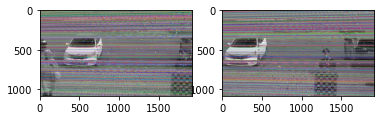

In [42]:
import cv2 as cv

img1 = cv.remap(img1, mapxL, mapyL, cv2.INTER_LINEAR)
img2 = cv.remap(img2, mapxR, mapyR, cv2.INTER_LINEAR)

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []

for i,(m,y) in enumerate(matches):
    if m.distance < 0.8*y.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()